# Data exploration in advance of model selection

Thanks to neptune.ai for their great tutorials in visualization; they were quite helpful here. Much of the visualization in this section was [described helpfully here](https://neptune.ai/blog/select-model-for-time-series-prediction-task).

### Import Libraries

In [156]:
import pandas as pd
# import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller



### Import data

The CSV here is an extract of the most recent Google BigQuery run of 'weekly_variables_flattened.sql'. My intent was to do this analysis in Google Colab, but as it turns out, activating that feature in my personal cloud instance would cost me about $400 on the low end, so instead I'll be doing it here.

In [157]:
# import data extracted from last GCP run of 'weekly_variables_flattened'
df = pd.read_csv("weekly_variables_flattened.csv")
df['week_start'] = pd.to_datetime(df['week_start'])
df = df.sort_values(by='week_start', ascending=True)
df.set_index('week_start', inplace=True)

In [158]:

print(df.head())
print(len(df))
# df = df.dropna()
print(len(df))

            approving  disapproving  unsure_or_no_data  BusinessApplications  \
week_start                                                                     
2004-07-04       48.0     48.333333           3.666667                159034   
2004-07-11       48.0     48.333333           3.666667                159034   
2004-07-18       48.0     48.333333           3.666667                159034   
2004-07-25       48.0     48.333333           3.666667                159034   
2004-08-01       50.0     46.500000           3.500000                191673   

            ConstructionSpending  DurableGoodsNewOrders  \
week_start                                                
2004-07-04             1006184.0               186835.0   
2004-07-11             1006184.0               186835.0   
2004-07-18             1006184.0               186835.0   
2004-07-25             1006184.0               186835.0   
2004-08-01             1013616.0               183728.0   

            International

## Data visualizations: The Dependent (Outcome) Variable

It is unfortunate that we do not have sufficient data at the current time to build a model through the current administration; at the time of this writing, the full tenure of the Biden presidency is not reflected in this data.

That said, in addition to the quality checks done in previous instances, the visualization in the first figure below can be [compared to prior work](https://ballotpedia.org/Joe_Biden%27s_executive_orders_and_actions) to see that the structure of the data is as would be expected.

### Seasonality

First, a simple trend of the outcome variable 'orders_outcome_var': we find some clear outliers that may need to be addressed prior to model implementation.

In [159]:
# df[['week_start', 'orders_outcome_var']].plot()
fig1 = px.line(df, x=df.index, y='orders_outcome_var')
fig1.update_layout(
    xaxis_title = 'Date',
    yaxis_title = 'No. Exec. Orders',
    title = 'Executive Orders by Date'
)
fig1.show()

We see below that there is a clear seasonal component to the data: this will require differencing (and suggests a SARIMA regression model be used).

In [160]:
fig2 = seasonal_decompose(x=df['orders_outcome_var'], model='additive')

fig2 = fig2.plot()

fig2.tight_layout(pad = 3)

fig2 = plotly.tools.mpl_to_plotly(fig2)
fig2.update_layout(
    title = 'Seasonal Decomposition showing strong seasonality',
    title_x = .1,
    title_y = .97
)
fig2.show();


### Autocorrelation

Prior to looking for autocorrelation, we will difference the data based on the seasonal period of one year.
Plotting *partial autocorrection correlation* indicates that there is a strong autocorrelation between high values in one period and a high value in the following time period.

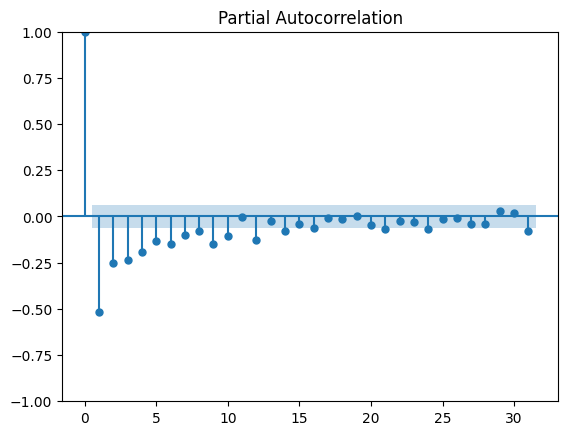

In [161]:
df['orders_outcome_var_diff']=df['orders_outcome_var']-df['orders_outcome_var'].shift() #differencing one year (52 weeks)
plot_pacf(df['orders_outcome_var_diff'].dropna());

### Stationarity

Given the wobbly trend line in the figure above, we will use the Dickey-Fuller test to examine stationarity. This is performed on the differenced data.

The results below indicate that the differenced data is now stationary (p < 0.05, by no small amount.)

In [162]:
adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(df['orders_outcome_var_diff'].dropna().values)

print('ADF test statistic:', adf)
print('ADF p-value:', pval)
print('Number of lags used:', usedlag)
print('Number of observations:', nobs)
print('Critical values:', crit_vals)
print('Best information criterion:', icbest)

ADF test statistic: -13.51328357251598
ADF p-value: 2.826005937992845e-25
Number of lags used: 15
Number of observations: 1053
Critical values: {'1%': np.float64(-3.4365753682419133), '5%': np.float64(-2.8642886771163396), '10%': np.float64(-2.568233502009814)}
Best information criterion: 5778.721360947314


Given these results, we will use a **Seasonal Auto-Regressive Integrated Moving Average with Exogeneous Variable** model to attempt to predict future counts of executive orders by week.